https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import tensorflow as tf
from tensorflow.keras import optimizers


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import the dataset from GoogleDrive

In [2]:
#Mount GoogleDrive account
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/QMUL/Semester2/Data Analytics/Project - M5/Jake/sales_train_validation.csv")
df.head

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<bound method NDFrame.head of                                   id        item_id  ... d_1912 d_1913
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  ...      1      1
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  ...      0      0
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  ...      1      1
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  ...      7      2
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  ...      2      4
...                              ...            ...  ...    ...    ...
30485    FOODS_3_823_WI_3_validation    FOODS_3_823  ...      0      1
30486    FOODS_3_824_WI_3_validation    FOODS_3_824  ...      1      0
30487    FOODS_3_825_WI_3_validation    FOODS_3_825  ...      1      0
30488    FOODS_3_826_WI_3_validation    FOODS_3_826  ...      1      3
30489    FOODS_3_827_WI_3_validation    FOODS_3_827  ...      0      0

[30490 rows x 1919 columns]>

# **Data Loading & Preprocessing**

In [0]:
#Remove unnecessary columns from the previous df
df1 = df.drop(['id', 'item_id', 'dept_id', 'cat_id', 'state_id'], axis=1)

#Merge by store_id
df1 = df1.groupby(['store_id']).sum()

#Set index and make states the columns
df1.index.names = [None]
df1 = df1.transpose()
df1.index = np.arange(1,len(df1)+1)
df1.reset_index(inplace=True)
df1.rename(columns={"index": "Day"}, inplace=True)

In [4]:
df1.shape

(1913, 11)

In [5]:
#See what the first few entries of the dataframe looks like
df1.head()

,Day,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
0,1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
1,2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
2,3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
3,4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
4,5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132


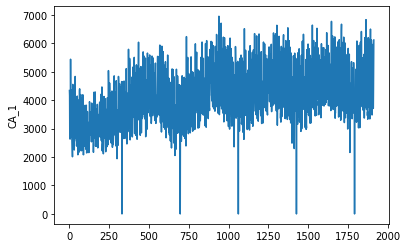

In [6]:
#See what the store sales of CA_1 looks like
sns.lineplot(x=df1.index, y="CA_1", data=df1);

In [7]:
#Split the dataset into train and test sets
TRAIN_SIZE = int(len(df1) * 0.9)
test_size = len(df1) - TRAIN_SIZE
train, test = df1.iloc[0:TRAIN_SIZE], df1.iloc[TRAIN_SIZE:len(df1)]
print(len(train), len(test))

1721 192


In [8]:
#Visualize the train set
train.head()

,Day,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
0,1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
1,2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
2,3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
3,4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
4,5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132


In [9]:
#Visualize the test set
test.head()

,Day,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
1721,1722,4122,4189,5769,2169,2899,3862,3525,3601,4621,3665
1722,1723,5582,5870,7446,2866,3624,4556,4490,4445,4556,4378
1723,1724,6214,5895,8037,2941,3940,4695,4338,4228,4409,4267
1724,1725,4094,3292,6022,2597,2887,3674,3555,3019,3309,2853
1725,1726,3717,3246,5514,2511,2437,3363,3283,2841,3218,2974


In [0]:
#Create function to feed data into the univariate model
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
#Use different seeds for random initializations
tf.random.set_seed(11)

# **Part 1: Forecast a univariate time series (CA_1)**

In [0]:
#Now that the data has been created, let's take a look at a single example
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
#Plot history data, true future and our prediction
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'go', 'rx']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

#Plot history data, true future and our prediction looking at just the tail of the plot
def show_plot_stretched(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'go', 'rx']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.figure(figsize=(24,6))
  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [0]:
all_store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

## **Baseline** (Creating a Model based on the mean history)

In [0]:
#Make a baseline model using mean to compare results of RNN model
def baseline(history):
  return np.mean(history)

Baseline Model Predictions for Table in Report
CA_1 - True Future: 3069
CA_1 - Model Prediction: 3101
CA_1 - Model Percentage Error: 1.04%
CA_2 - True Future: 2064
CA_2 - Model Prediction: 2413
CA_2 - Model Percentage Error: 16.91%
CA_3 - True Future: 4498
CA_3 - Model Prediction: 4159
CA_3 - Model Percentage Error: 7.54%
CA_4 - True Future: 1633
CA_4 - Model Prediction: 1468
CA_4 - Model Percentage Error: 10.10%
TX_1 - True Future: 2482
TX_1 - Model Prediction: 2219
TX_1 - Model Percentage Error: 10.60%
TX_2 - True Future: 3246
TX_2 - Model Prediction: 2958
TX_2 - Model Percentage Error: 8.87%
TX_3 - True Future: 2273
TX_3 - Model Prediction: 2250
TX_3 - Model Percentage Error: 1.01%
WI_1 - True Future: 1169
WI_1 - Model Prediction: 1615
WI_1 - Model Percentage Error: 38.15%
WI_2 - True Future: 1573
WI_2 - Model Prediction: 1691
WI_2 - Model Percentage Error: 7.50%
WI_3 - True Future: 3017
WI_3 - Model Prediction: 3225
WI_3 - Model Percentage Error: 6.89%


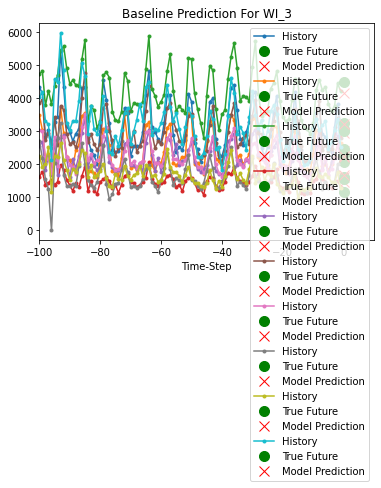

In [16]:
#Traverse through CA, TX and WI

print('Baseline Model Predictions for Table in Report')
print('====================================')

for store_id in all_store_ids:

  uni_data = df1[store_id]
  uni_data.index = df1['Day']

  '''Let's observe how this data looks across time'''

  # plt.figure(figsize=(36, 6))
  # plt.plot(uni_data, linewidth=1)
  # plt.ylabel('Unit Sales (y)')
  # plt.xlabel('Day (x)')
  # plt.title('Plot Showing the Aggregated Unit Sales per Day for Store {}'.format(store_id))
  # plt.show()

  '''Let's standardize the data'''

  uni_data = uni_data.values

  # uni_train_mean = uni_data[:TRAIN_SIZE].mean()
  # uni_train_std = uni_data[:TRAIN_SIZE].std()
  
  # standardized_uni_data = (uni_data-uni_train_mean)/uni_train_std

  '''Let's now create the data for the univariate model'''

  univariate_past_history = 100
  univariate_future_target = 0

  x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SIZE,
                                             univariate_past_history,
                                             univariate_future_target)
  x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SIZE, None,
                                         univariate_past_history,
                                         univariate_future_target)
  
  plot = show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
                   'Baseline Prediction For {}'.format(store_id))

  true_future = y_train_uni[0]
  model_prediction = int(baseline(x_train_uni[0]))
  model_percentage_error = (abs(true_future - model_prediction) / true_future) * 100
  
  print('{} - True Future:'.format(store_id), true_future)
  print('{} - Model Prediction:'.format(store_id), model_prediction)
  print('{} - Model Percentage Error: {:0.2f}%'.format(store_id, model_percentage_error))
  print('====================================')



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

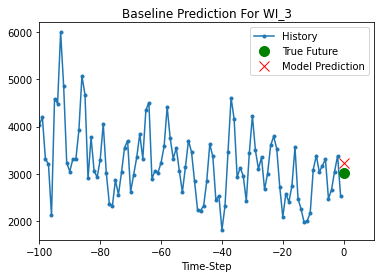

In [17]:
#Show sample baseline prediction
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction For WI_3')

## **Recurrent Neural Network (RNN)**

## **Predict single step using the simple LSTM model**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________

Training Model for CA_1...

Epoch 1/100
50/50 [==============================] - 2s 46ms/step - loss: 0.7458 - val_loss: 0.7142
Epoch 2/100
50/50 [==============================] - 2s 35ms/step - loss: 0.6668 - val_loss: 0.6774
Epoch 3/100
50/50 [==============================] - 2s 35ms/step - loss: 0.6309 - val_loss: 0.6362
Epoch 4/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6014 - val_loss: 0.6020
Epoch 5/100
50/50 [==============================] - 2s 36ms/step - loss: 0.5691 - val_loss

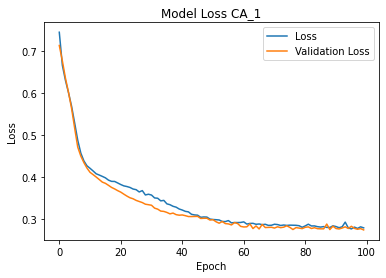

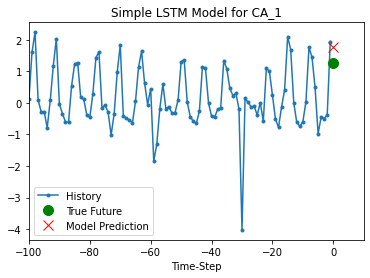

CA_1 - True Future: 5247
CA_1 - Model Prediction: 5737
CA_1 - Model Percentage Error: 9.34%
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________

Training Model for CA_2...

Epoch 1/100
50/50 [==============================] - 2s 42ms/step - loss: 0.7545 - val_loss: 1.2934
Epoch 2/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6999 - val_loss: 1.2619
Epoch 3/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6852 - val_loss: 1.2068
Epoch 4/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6599 - val_loss: 1.14

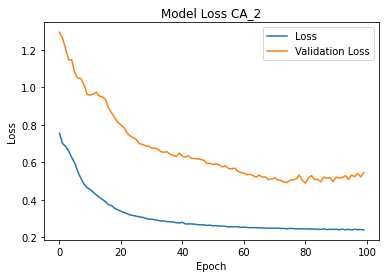

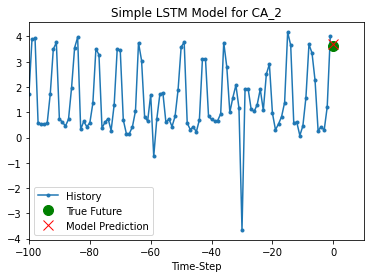

CA_2 - True Future: 5647
CA_2 - Model Prediction: 5713
CA_2 - Model Percentage Error: 1.17%
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________

Training Model for CA_3...

Epoch 1/100
50/50 [==============================] - 2s 44ms/step - loss: 0.6617 - val_loss: 0.6801
Epoch 2/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6098 - val_loss: 0.6556
Epoch 3/100
50/50 [==============================] - 2s 36ms/step - loss: 0.5953 - val_loss: 0.6291
Epoch 4/100
50/50 [==============================] - 2s 36ms/step - loss: 0.5810 - val_loss: 0.61

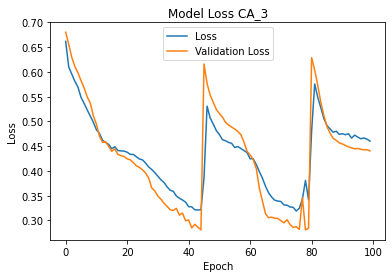

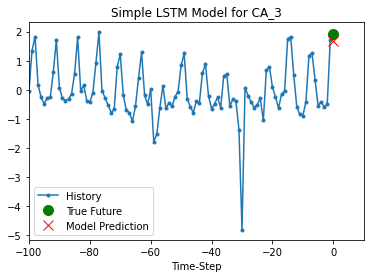

CA_3 - True Future: 8164
CA_3 - Model Prediction: 7855
CA_3 - Model Percentage Error: 3.78%
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________

Training Model for CA_4...

Epoch 1/100
50/50 [==============================] - 2s 42ms/step - loss: 0.5427 - val_loss: 0.6295
Epoch 2/100
50/50 [==============================] - 2s 35ms/step - loss: 0.5181 - val_loss: 0.6425
Epoch 3/100
50/50 [==============================] - 2s 36ms/step - loss: 0.5098 - val_loss: 0.6106
Epoch 4/100
50/50 [==============================] - 2s 36ms/step - loss: 0.4984 - val_loss: 0.59

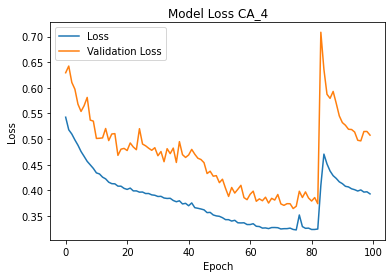

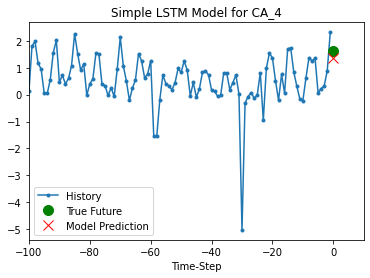

CA_4 - True Future: 2787
CA_4 - Model Prediction: 2679
CA_4 - Model Percentage Error: 3.88%
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________

Training Model for TX_1...

Epoch 1/100
50/50 [==============================] - 2s 42ms/step - loss: 0.7462 - val_loss: 0.6933
Epoch 2/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6933 - val_loss: 0.6920
Epoch 3/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6831 - val_loss: 0.6701
Epoch 4/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6646 - val_loss: 0.65

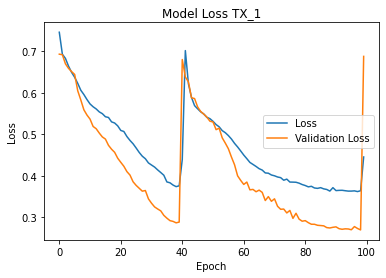

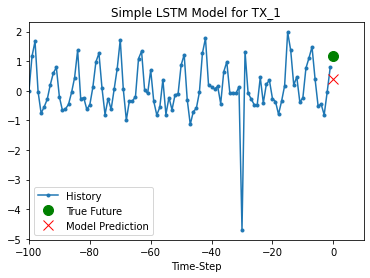

TX_1 - True Future: 3639
TX_1 - Model Prediction: 3144
TX_1 - Model Percentage Error: 13.60%
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________

Training Model for TX_2...

Epoch 1/100
50/50 [==============================] - 2s 42ms/step - loss: 0.7648 - val_loss: 0.6955
Epoch 2/100
50/50 [==============================] - 2s 36ms/step - loss: 0.7015 - val_loss: 0.6720
Epoch 3/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6792 - val_loss: 0.6438
Epoch 4/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6581 - val_loss: 0.6

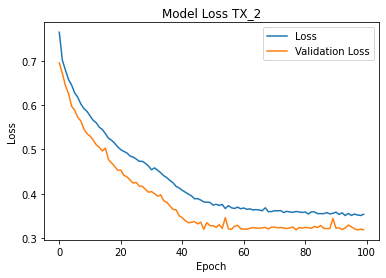

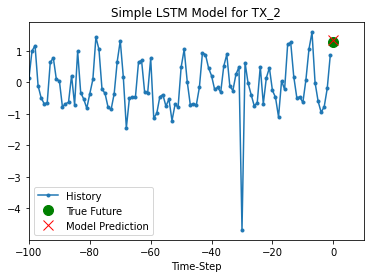

TX_2 - True Future: 4794
TX_2 - Model Prediction: 4841
TX_2 - Model Percentage Error: 0.98%
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________

Training Model for TX_3...

Epoch 1/100
50/50 [==============================] - 2s 42ms/step - loss: 0.6459 - val_loss: 0.6476
Epoch 2/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6314 - val_loss: 0.6511
Epoch 3/100
50/50 [==============================] - 2s 37ms/step - loss: 0.6200 - val_loss: 0.6477
Epoch 4/100
50/50 [==============================] - 2s 37ms/step - loss: 0.6138 - val_loss: 0.63

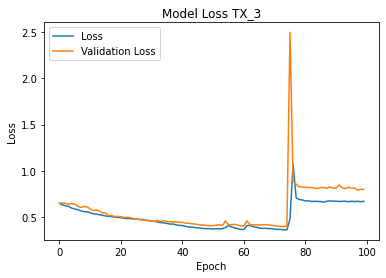

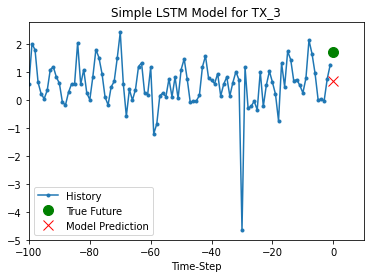

TX_3 - True Future: 4286
TX_3 - Model Prediction: 3588
TX_3 - Model Percentage Error: 16.29%
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________

Training Model for WI_1...

Epoch 1/100
50/50 [==============================] - 2s 43ms/step - loss: 0.5713 - val_loss: 0.8216
Epoch 2/100
50/50 [==============================] - 2s 36ms/step - loss: 0.5046 - val_loss: 0.8310
Epoch 3/100
50/50 [==============================] - 2s 36ms/step - loss: 0.4947 - val_loss: 0.8137
Epoch 4/100
50/50 [==============================] - 2s 37ms/step - loss: 0.4902 - val_loss: 0.8

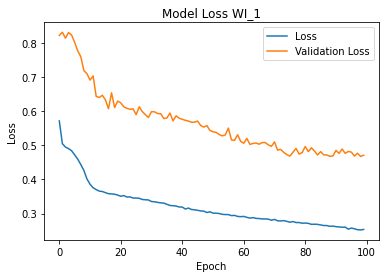

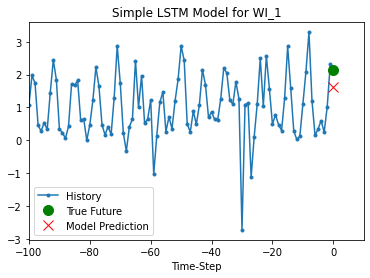

WI_1 - True Future: 4600
WI_1 - Model Prediction: 4116
WI_1 - Model Percentage Error: 10.52%
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________

Training Model for WI_2...

Epoch 1/100
50/50 [==============================] - 2s 42ms/step - loss: 0.5539 - val_loss: 0.8136
Epoch 2/100
50/50 [==============================] - 2s 36ms/step - loss: 0.4149 - val_loss: 0.7625
Epoch 3/100
50/50 [==============================] - 2s 36ms/step - loss: 0.3994 - val_loss: 0.7318
Epoch 4/100
50/50 [==============================] - 2s 37ms/step - loss: 0.3966 - val_loss: 0.7

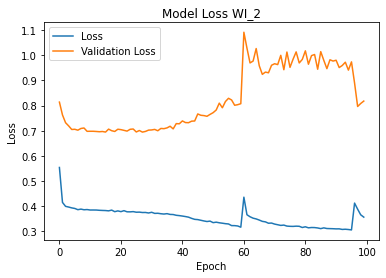

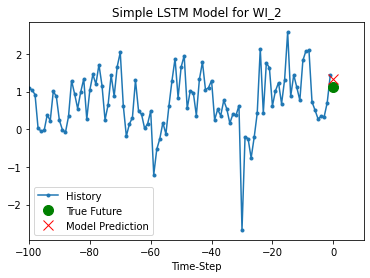

WI_2 - True Future: 4670
WI_2 - Model Prediction: 4913
WI_2 - Model Percentage Error: 5.20%
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________

Training Model for WI_3...

Epoch 1/100
50/50 [==============================] - 2s 42ms/step - loss: 0.7429 - val_loss: 0.8281
Epoch 2/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6751 - val_loss: 0.8314
Epoch 3/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6618 - val_loss: 0.8275
Epoch 4/100
50/50 [==============================] - 2s 36ms/step - loss: 0.6544 - val_loss: 0.81

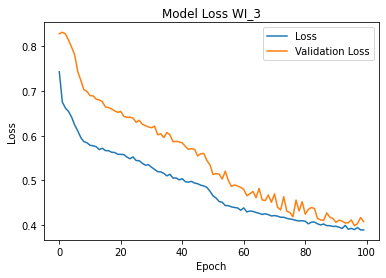

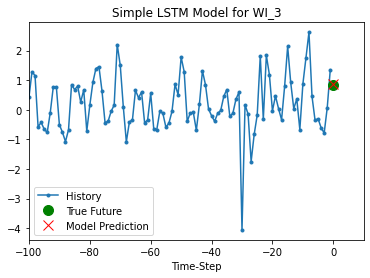

WI_3 - True Future: 3998
WI_3 - Model Prediction: 4037
WI_3 - Model Percentage Error: 0.98%


In [18]:
#Hyperparameters
BATCH_SIZE = 128
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 50
EPOCHS = 100

univariate_past_history = 100
univariate_future_target = 0

#Get all store id's (one by one) for each state
for store_id in all_store_ids:
  uni_data = df1[store_id]
  uni_data.index = df1['Day']

  #Standardize the dataset

  uni_data = uni_data.values

  uni_train_mean = uni_data[:TRAIN_SIZE].mean()
  uni_train_std = uni_data[:TRAIN_SIZE].std()
  
  standardized_uni_data = (uni_data-uni_train_mean)/uni_train_std

  #Split training and validation data
  x_train_uni, y_train_uni = univariate_data(standardized_uni_data, 0, TRAIN_SIZE,
                                             univariate_past_history,
                                             univariate_future_target)
  x_val_uni, y_val_uni = univariate_data(standardized_uni_data, TRAIN_SIZE, None,
                                         univariate_past_history,
                                         univariate_future_target)
  
  #Transform data to the form of a tensor and cache it in memory
  train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
  train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
  val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

  #Build LSTM layer for model
  simple_lstm_model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
      tf.keras.layers.Dense(1)
  ])

  #Compile Neural network
  sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  simple_lstm_model.compile(optimizer=sgd,
                loss='mae')
  
  simple_lstm_model.summary()
  
  #Train the model
  print()
  print('Training Model for {}...'.format(store_id))
  print()

  history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                        steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=val_univariate, validation_steps=10)
  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("Model Loss {}".format(store_id))
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend(["Loss","Validation Loss"])
  plt.show()

  #Predict a single-step future
  for x, y in val_univariate.take(1):
    true_future = int(y[0].numpy() * uni_train_std + uni_train_mean)
    model_prediction = int(simple_lstm_model.predict(x)[0] * uni_train_std + uni_train_mean)
    model_percentage_error = (abs(true_future - model_prediction) / true_future) * 100

    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM Model for {}'.format(store_id))
    plot.show()

    print('{} - True Future:'.format(store_id), true_future)
    print('{} - Model Prediction:'.format(store_id), model_prediction)
    print('{} - Model Percentage Error: {:0.2f}%'.format(store_id, model_percentage_error))
    print('====================================')
    print('====================================')

  

## **Multi-step**

In [0]:
#Hyperparameters
BATCH_SIZE = 128
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 50
EPOCHS = 100
STEP = 1
LEARNING_RATE = 0.01
MOMENTUM = 0.9
DECAY = 1e-6

multi_step_univariate_past_history = 100
multi_step_univariate_future_target = 20

In [0]:
#Plotting a sample data-point 
def multi_step_plot(history, true_future, prediction, title):
  plt.figure(figsize=(21, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'rx',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title(title)
  plt.ylabel("Standardised Prediction")
  plt.xlabel("Day")
  plt.show()

def multi_step_plot_tail(history, true_future, prediction, title):
  plt.figure(figsize=(18, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'rx',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.xlim([-10, multi_step_univariate_future_target])
  plt.title(title)
  plt.ylabel("Standardised Prediction")
  plt.xlabel("Day")
  plt.show()

In [0]:
#This function returns the first N days of history data and the value N+1 as the label
#The size of the dataset will depend on the value of TRAIN_SIZE

def multi_step_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 32)           4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 20)                340       
Total params: 7,828
Trainable params: 7,828
Non-trainable params: 0
_________________________________________________________________

Training Model for CA_1...

Epoch 1/100
50/50 [==============================] - 5s 105ms/step - loss: 0.7785 - val_loss: 0.7210
Epoch 2/100
50/50 [==============================] - 5s 96ms/step - loss: 0.7737 - val_loss: 0.7230
Epoch 3/100
50/50 [==============================] - 5s 96ms/step - loss: 0.7682 - val_loss: 0.7249
Epoch 4/100
50/50 [==============================] - 5

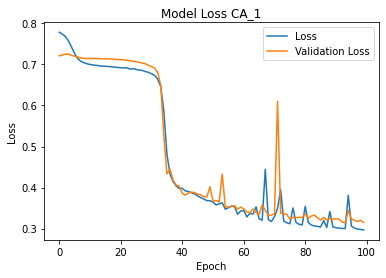

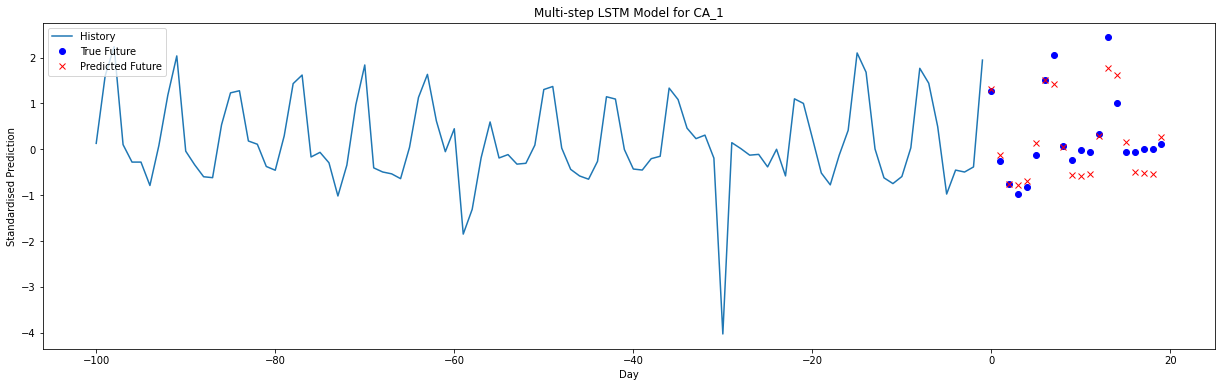

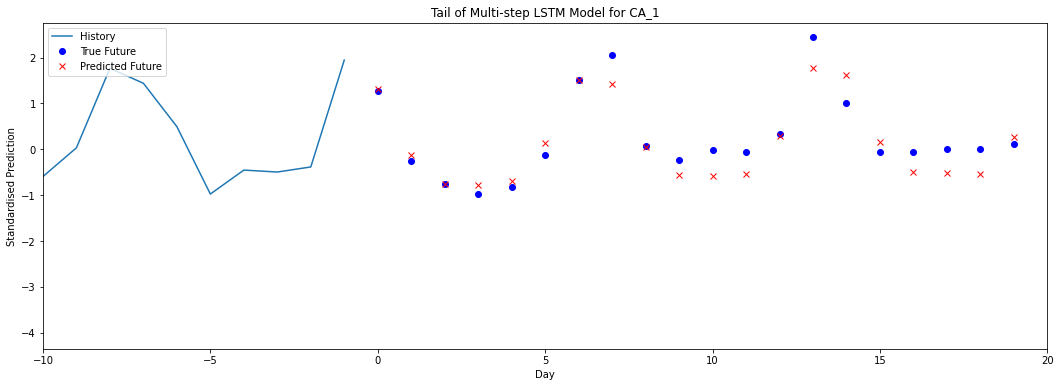

CA_1 - True Future: [5247. 3741. 3246. 3031. 3173. 3871. 5498. 6032. 4075. 3765. 3983. 3928.
 4327. 6412. 4986. 3933. 3936. 3995. 4007. 4111.]
CA_1 - Model Prediction: [5297.7705 3869.7148 3251.8677 3229.2107 3307.641  4135.6143 5489.141
 5408.6123 4048.81   3436.8245 3415.849  3457.141  4290.7075 5746.8857
 5592.803  4154.2793 3493.5715 3481.8591 3470.105  4249.8003]
CA_1 - Model Percentage Error: [ 0.96761021  3.4406534   0.18076635  6.53944881  4.24333795  6.83581136
  0.16112926 10.33467665  0.64269795  8.71648173 14.23928895 11.98724253
  0.83874464 10.37296098 12.17014085  5.62622163 11.24056064 12.84457745
 13.39892737  3.37631459]%
CA_1 - Model Mean Percentage Error: 6.90787966515976%
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 32)           4352      
_________________________________________________________________
lstm_3 (LSTM

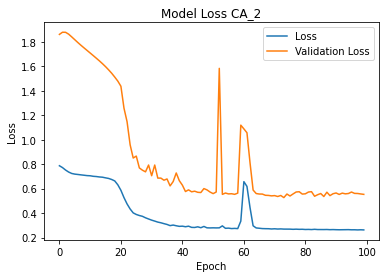

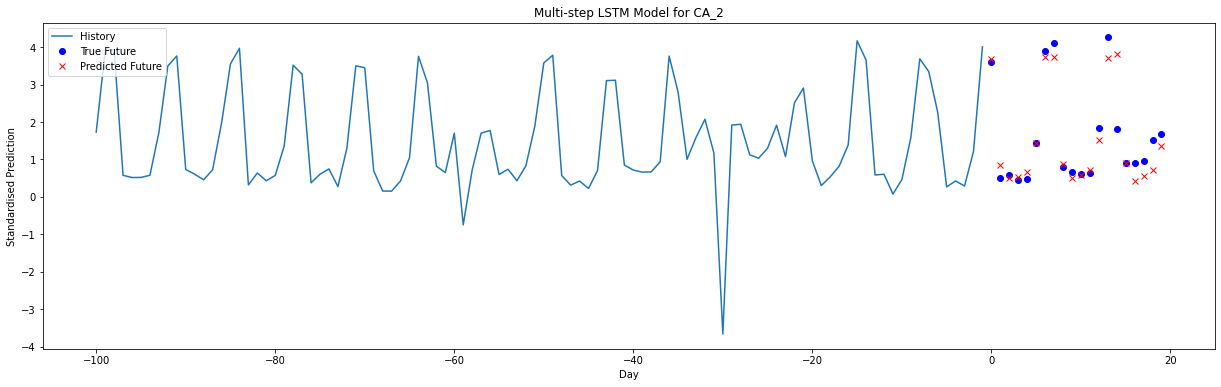

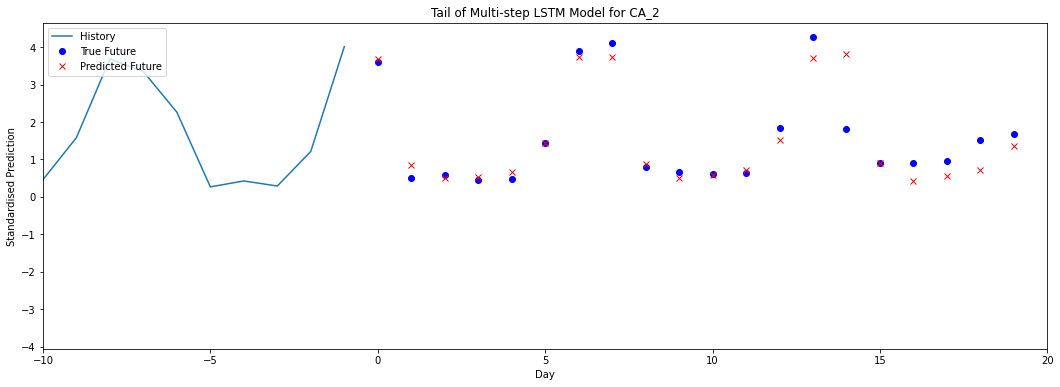

CA_2 - True Future: [5647. 3240. 3294. 3189. 3211. 3964. 5873. 6037. 3454. 3360. 3314. 3333.
 4276. 6150. 4251. 3537. 3549. 3586. 4026. 4140.]
CA_2 - Model Prediction: [5699.5073 3505.1243 3244.9111 3249.5967 3370.7979 3969.3823 5753.3
 5753.3823 3533.2393 3235.5745 3306.2349 3401.4568 4017.303  5731.5083
 5804.383  3545.407  3176.892  3284.1462 3396.9888 3906.7148]
CA_2 - Model Percentage Error: [ 0.92982689  8.18284776  1.49025098  1.9001781   4.97657588  0.13578013
  2.03814397  4.69799032  2.29413022  3.70314099  0.23431312  2.053909
  6.04997712  6.80474308 36.5415858   0.23768681 10.48486645  8.41756162
 15.62372654  5.63490716]%
CA_2 - Model Mean Percentage Error: 6.121607096258087%
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 32)           4352      
_________________________________________________________________
lstm_5 (LSTM)  

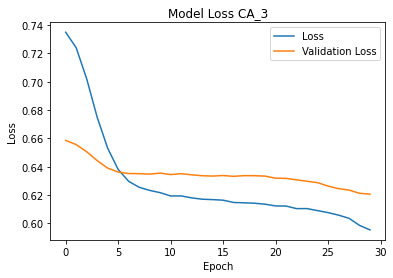

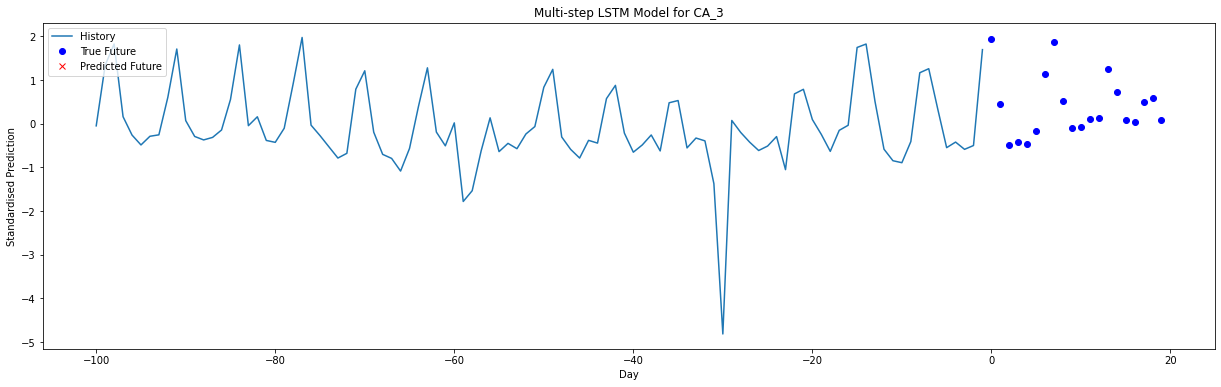

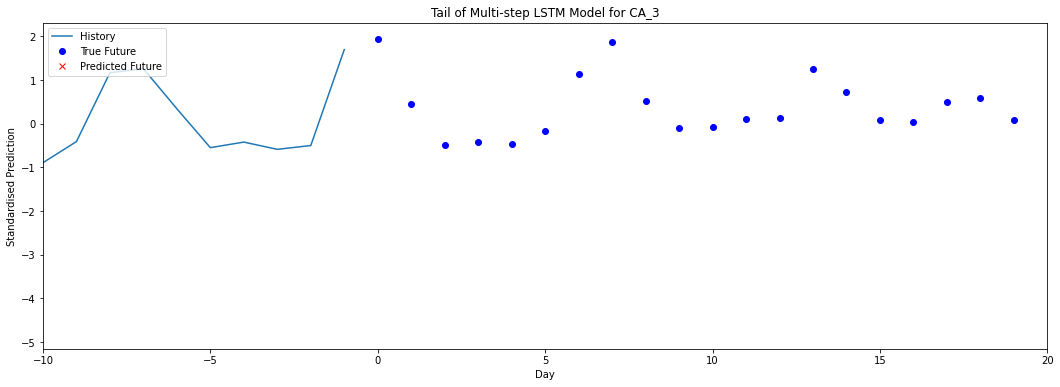

CA_3 - True Future: [8164. 6371. 5244. 5309. 5261. 5637. 7217. 8094. 6446. 5722. 5740. 5951.
 5986. 7347. 6696. 5930. 5882. 6421. 6547. 5928.]
CA_3 - Model Prediction: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
CA_3 - Model Percentage Error: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]%
CA_3 - Model Mean Percentage Error: nan%
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 32)           4352      
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                340       
Total params: 7,828
Trainable params: 7,828
Non-trainable params: 0
_________________________________________

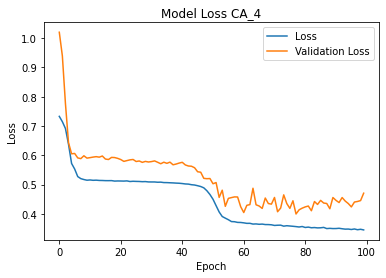

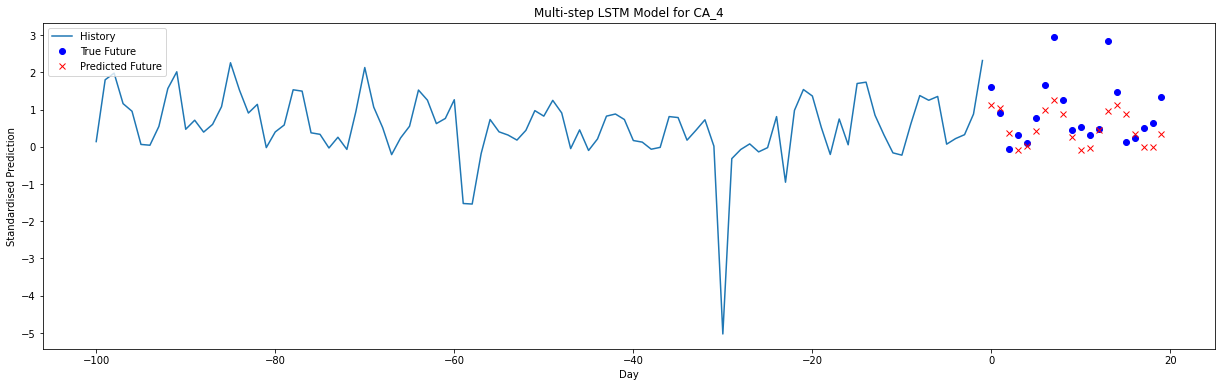

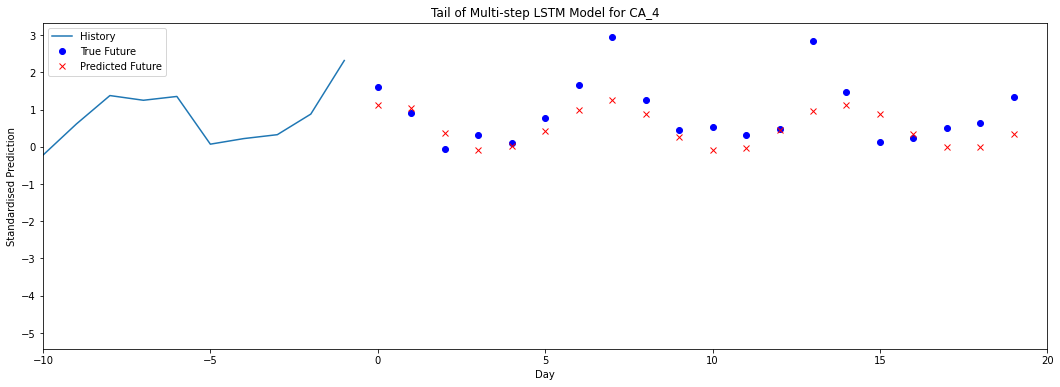

CA_4 - True Future: [2787. 2487. 2088. 2239. 2153. 2432. 2806. 3343. 2643. 2299. 2335. 2244.
 2316. 3301. 2727. 2166. 2207. 2323. 2383. 2677.]
CA_4 - Model Prediction: [2586.3533 2552.3945 2268.334  2069.4392 2115.1257 2283.9722 2525.374
 2635.3662 2485.013  2223.1692 2076.7346 2100.9812 2299.8374 2515.6304
 2585.7988 2477.6208 2259.7822 2106.9192 2109.4597 2255.6118]
CA_4 - Model Percentage Error: [ 7.19938028  2.62945441  8.63668508  7.573059    1.75913923  6.08667072
 10.00092575 21.16762755  5.97756567  3.29842586 11.06061588  6.37338676
  0.69786691 23.79187001  5.17789409 14.3869275   2.39158254  9.30179985
 11.47882011 15.74106028]%
CA_4 - Model Mean Percentage Error: 8.736537873698989%
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100, 32)           4352      
_________________________________________________________________
lstm_9 (LST

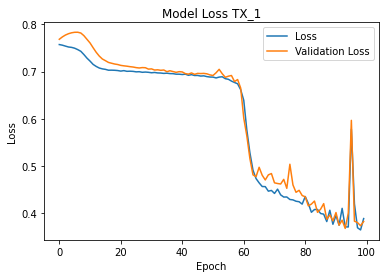

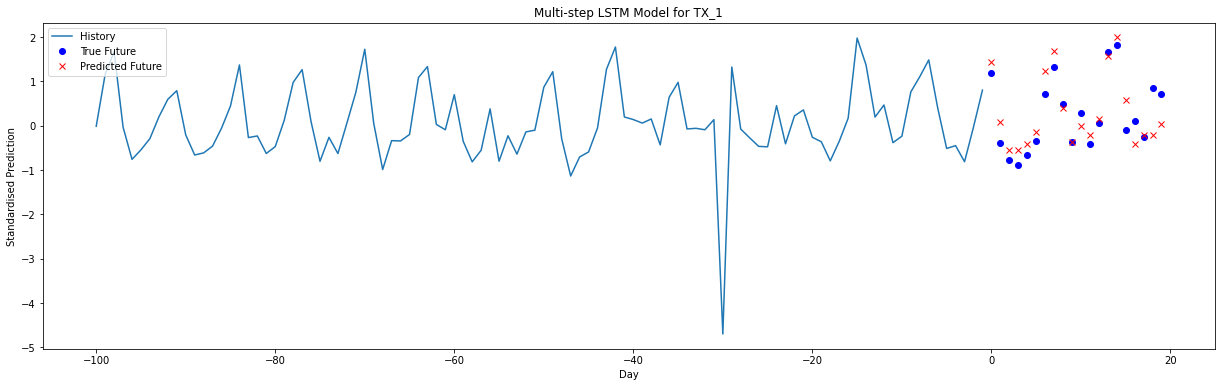

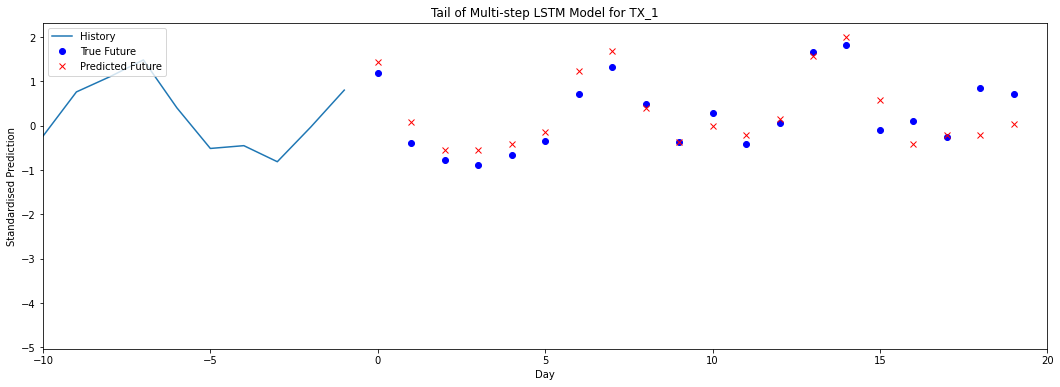

TX_1 - True Future: [3639. 2666. 2426. 2357. 2497. 2693. 3347. 3727. 3213. 2681. 3081. 2645.
 2949. 3939. 4034. 2845. 2978. 2745. 3431. 3343.]
TX_1 - Model Prediction: [3791.6372 2963.8184 2568.6348 2565.0347 2649.8923 2818.942  3674.6724
 3952.4248 3157.2505 2677.0845 2897.9067 2776.2488 3004.5947 3883.8943
 4137.339  3268.0076 2655.1804 2780.2554 2776.5735 2934.469 ]
TX_1 - Model Percentage Error: [ 4.19448219 11.17098122  5.8794215   8.82624811  6.12304101  4.67663923
  9.79003177  6.04842513  1.7351233   0.14604727  5.94265699  4.96214667
  1.88520606  1.39897722  2.56169725 14.86845583 10.84014708  1.28434867
 19.07392928 12.22049075]%
TX_1 - Model Mean Percentage Error: 6.681424827341222%
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100, 32)           4352      
_________________________________________________________________
lstm_11 (L

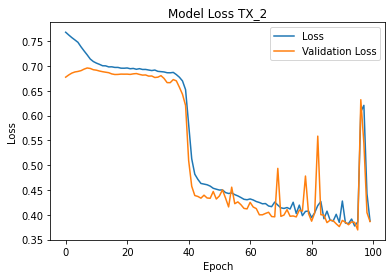

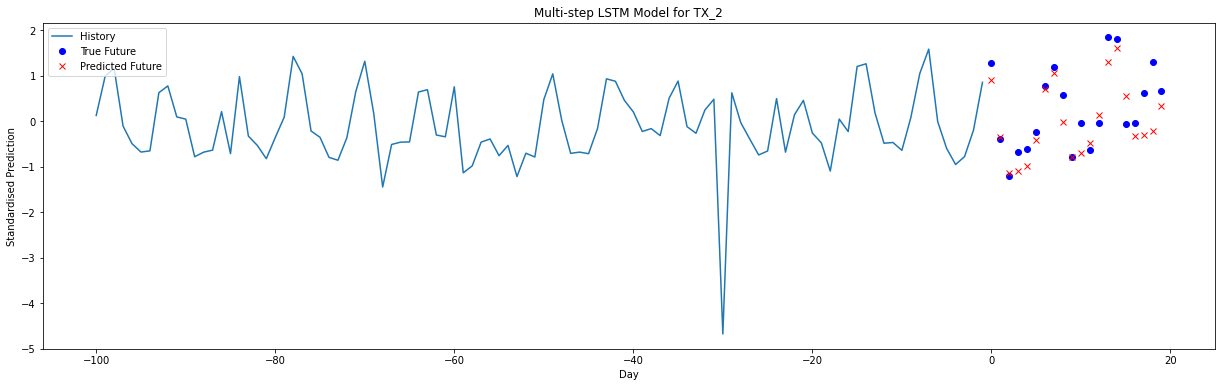

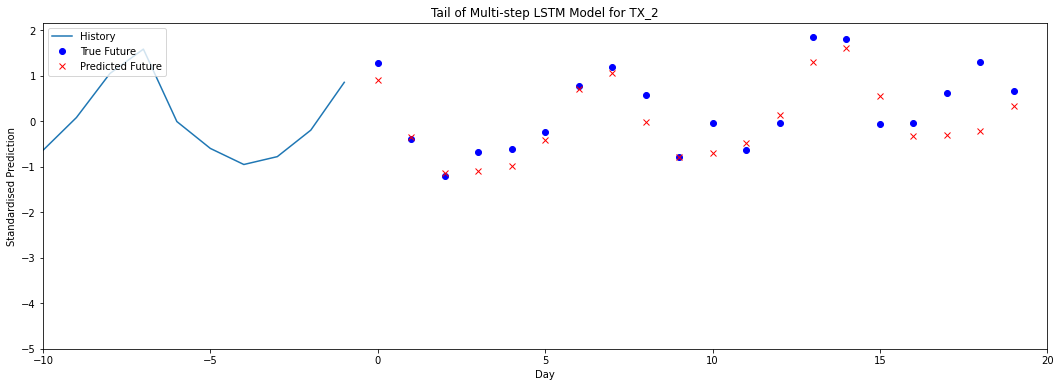

TX_2 - True Future: [4794. 3441. 2798. 3216. 3264. 3562. 4384. 4712. 4225. 3121. 3722. 3245.
 3737. 5240. 5210. 3714. 3737. 4259. 4799. 4295.]
TX_2 - Model Prediction: [4493.698  3487.2004 2843.6213 2882.6768 2971.0254 3425.667  4335.447
 4613.0767 3748.2979 3119.6987 3204.0527 3381.6516 3878.152  4801.1465
 5049.0522 4210.317  3498.9414 3524.2556 3578.657  4024.319 ]
TX_2 - Model Percentage Error: [ 6.26411677  1.34264573  1.63049814 10.36452867  8.97593779  3.82742863
  1.10750964  2.09939176 11.28289109  0.04169399 13.91583196  4.21114365
  3.77715011  8.37506709  3.08920833 13.36340588  6.37031292 17.25157043
 25.4291106   6.30223302]%
TX_2 - Model Mean Percentage Error: 7.4510838099827765%
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 32)           4352      
_________________________________________________________________
lstm_13 (L

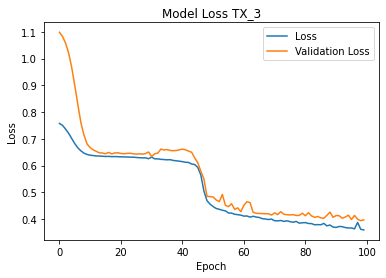

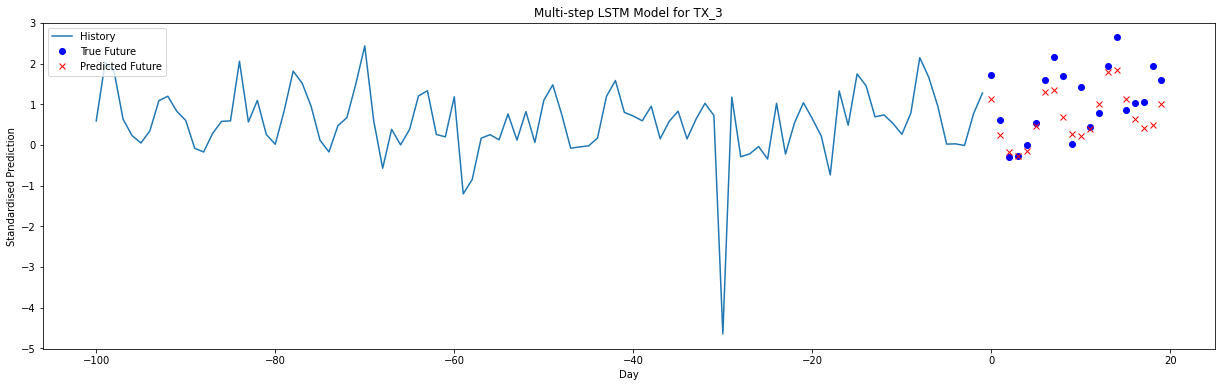

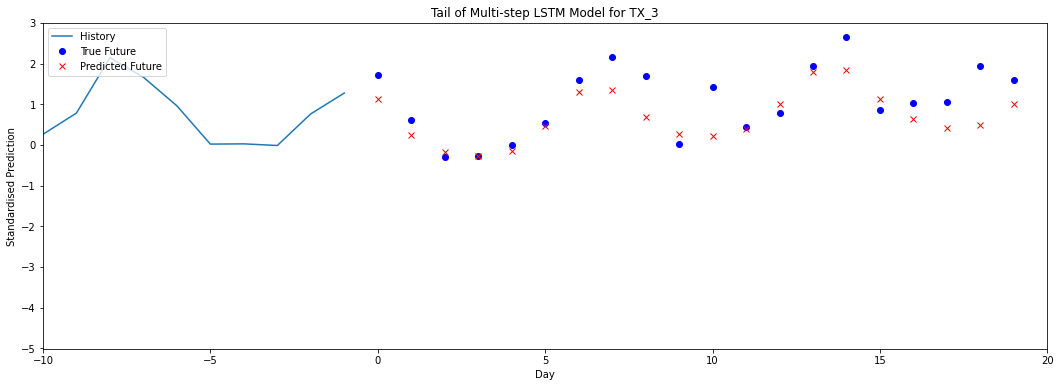

TX_3 - True Future: [4286. 3538. 2934. 2939. 3135. 3486. 4202. 4575. 4262. 3141. 4091. 3421.
 3664. 4432. 4905. 3707. 3825. 3831. 4438. 4198.]
TX_3 - Model Prediction: [3890.4287 3295.672  3008.013  2951.893  3021.3513 3435.763  4009.3904
 4043.0994 3598.146  3307.0222 3277.831  3387.494  3802.7363 4327.838
 4371.5356 3884.1936 3560.049  3413.963  3457.9084 3797.3726]
TX_3 - Model Percentage Error: [ 9.22938145  6.84929002  2.52259507  0.43868889  3.62515731  1.44110902
  4.58376057 11.62624338 15.57611459  5.28564842 19.8770214   0.97942425
  3.78647184  2.3502281  10.87592978  4.77997312  6.92682164 10.88585511
 22.08408186  9.54329303]%
TX_3 - Model Mean Percentage Error: 7.663354441993991%
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 100, 32)           4352      
_________________________________________________________________
lstm_15 (LS

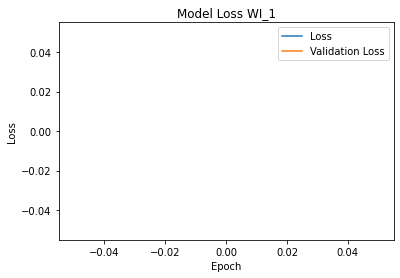

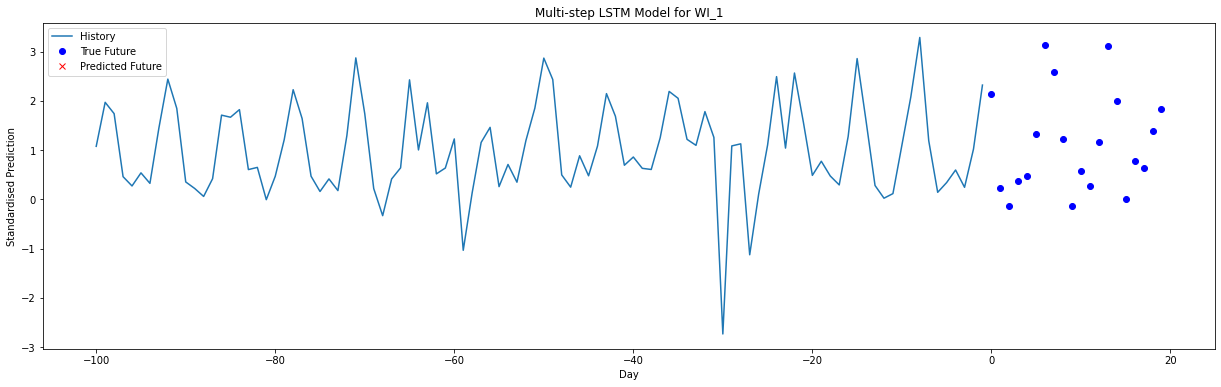

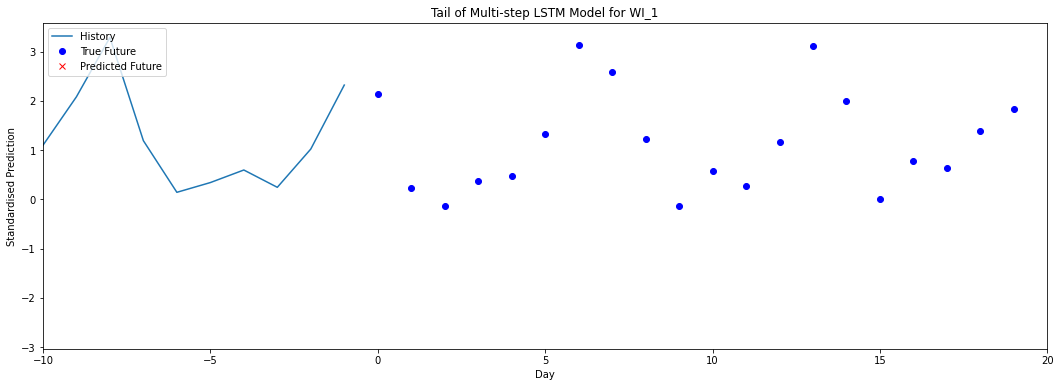

WI_1 - True Future: [4600. 2798. 2466. 2937. 3036. 3845. 5538. 5034. 3740. 2460. 3135. 2831.
 3676. 5516. 4461. 2597. 3313. 3180. 3899. 4308.]
WI_1 - Model Prediction: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
WI_1 - Model Percentage Error: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]%
WI_1 - Model Mean Percentage Error: nan%
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 100, 32)           4352      
_________________________________________________________________
lstm_17 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                340       
Total params: 7,828
Trainable params: 7,828
Non-trainable params: 0
_________________________________________

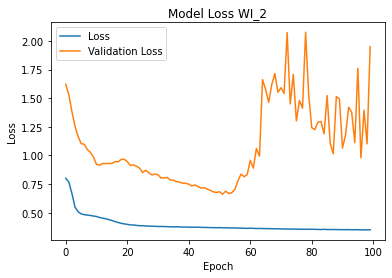

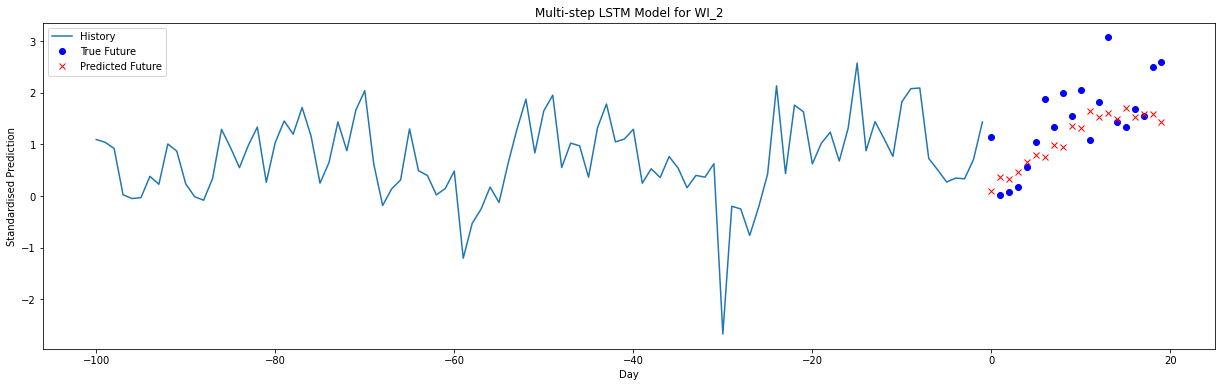

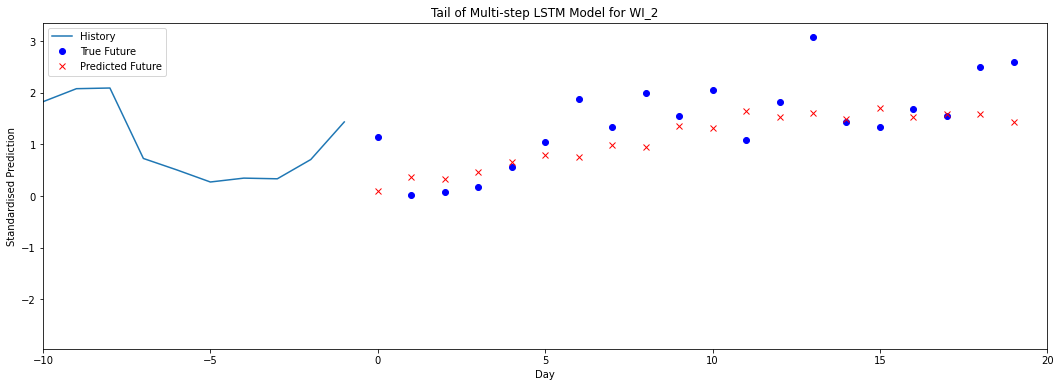

WI_2 - True Future: [4670. 3301. 3386. 3500. 3961. 4569. 5586. 4915. 5718. 5169. 5786. 4607.
 5506. 7046. 5046. 4907. 5358. 5180. 6333. 6463.]
WI_2 - Model Prediction: [3407.3179 3730.9277 3673.1982 3839.2295 4094.4307 4254.5283 4212.216
 4492.188  4439.4297 4947.9785 4905.7886 5292.851  5164.5747 5262.3745
 5113.811  5376.7793 5155.831  5237.971  5218.32   5040.101 ]
WI_2 - Model Percentage Error: [27.03816122 13.02416645  8.48193273  9.69227121  3.36861055  6.88272444
 24.59334371  8.60248244 22.36044618  4.27590413 15.21277957 14.8871516
  6.20096791 25.31401488  1.34385722  9.57365594  3.7732166   1.11913497
 17.60113968 22.01607498]%
WI_2 - Model Mean Percentage Error: 12.268101818786054%
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100, 32)           4352      
_________________________________________________________________
lstm_19 (LS

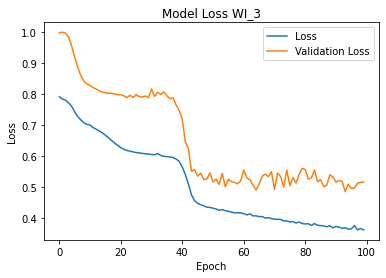

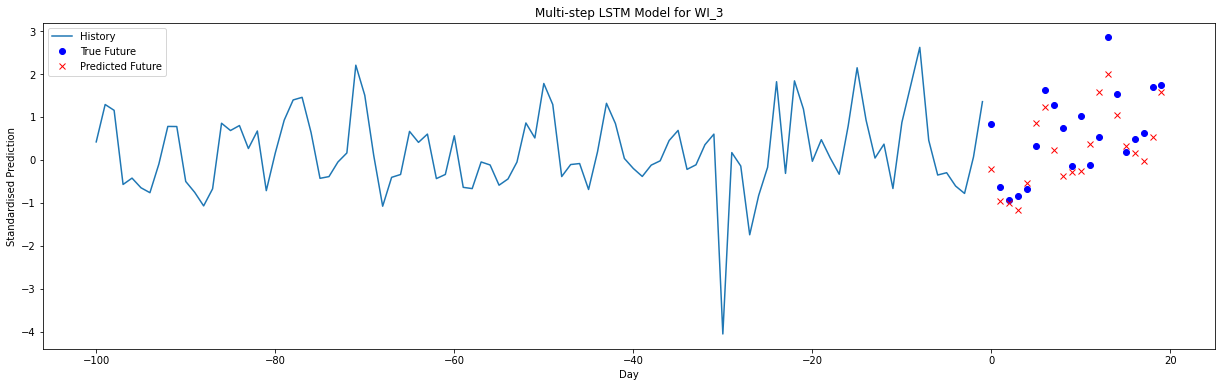

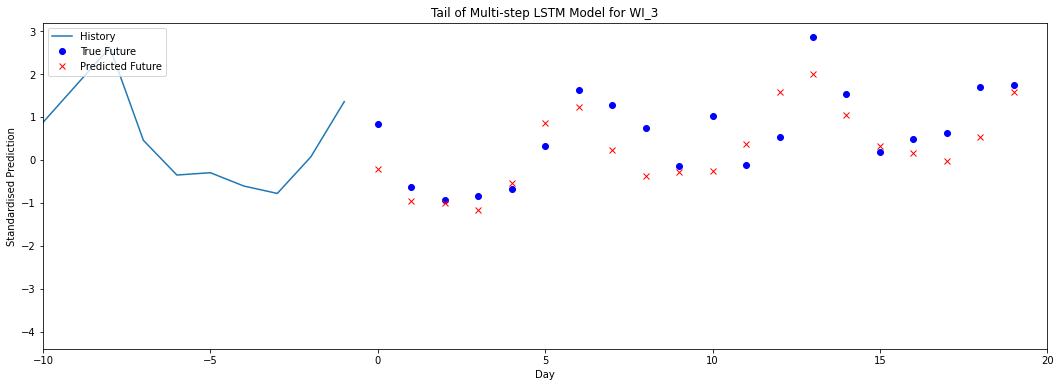

WI_3 - True Future: [3998. 2806. 2564. 2632. 2775. 3580. 4653. 4362. 3938. 3210. 4153. 3219.
 3756. 5657. 4577. 3468. 3728. 3833. 4721. 4759.]
WI_3 - Model Prediction: [3154.5981 2538.5852 2507.8855 2365.0693 2879.7893 4023.5117 4327.9727
 3516.1267 3019.6243 3088.81   3116.8713 3630.8552 4623.9165 4967.118
 4170.9233 3581.0745 3449.7378 3305.877  3767.566  4617.9155]
WI_3 - Model Percentage Error: [21.09559418  9.53010673  2.18855312 10.14174256  3.77619123 12.3885955
  6.98532869 19.3918682  23.32086675  3.77538758 24.94892035 12.79450838
 23.10746816 12.1951889   8.87211405  3.26050931  7.464115   13.75223185
 20.19559589  2.96458232]%
WI_3 - Model Mean Percentage Error: 12.10747343664389%


In [0]:

#Get all store id's (one by one)
for store_id in all_store_ids:
  uni_data = df1[store_id]
  uni_data.index = df1['Day']

  #Standardize the dataset
  uni_data = uni_data.values

  uni_train_mean = uni_data[:TRAIN_SIZE].mean()
  uni_train_std = uni_data[:TRAIN_SIZE].std()
  
  standardized_uni_data = (uni_data-uni_train_mean)/uni_train_std

  #Split training and validation data
  x_train_multi, y_train_multi = multi_step_data(standardized_uni_data, standardized_uni_data, 0,
                                                 TRAIN_SIZE, multi_step_univariate_past_history,
                                                 multi_step_univariate_future_target, STEP)
  x_val_multi, y_val_multi = multi_step_data(standardized_uni_data, standardized_uni_data, TRAIN_SIZE,
                                             None, multi_step_univariate_past_history,
                                             multi_step_univariate_future_target, STEP) 

  #The train parameters have to be a 3d vector, when we are using a univariate we have to reshape
  x_train_multi = np.expand_dims(x_train_multi, axis=2) 
  x_val_multi = np.expand_dims(x_val_multi, axis=2)

  #Transform data to the form of a tensor and cache it in memory
  train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
  train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
  val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

  #Define Neural Network structure
  multi_step_model = tf.keras.models.Sequential()
  multi_step_model.add(tf.keras.layers.LSTM(32,
                                            return_sequences=True,
                                            input_shape=x_train_multi.shape[-2:]))
  multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
  multi_step_model.add(tf.keras.layers.Dense(multi_step_univariate_future_target))

  #Compile Neural network 
  sgd = optimizers.SGD(learning_rate=LEARNING_RATE, decay=DECAY, momentum=MOMENTUM, nesterov=True)
  multi_step_model.compile(optimizer=sgd,
                           loss='mae')
  multi_step_model.summary()

  #Train the model
  print()
  print('Training Model for {}...'.format(store_id))
  print()

  history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=10)
  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("Model Loss {}".format(store_id))
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend(["Loss","Validation Loss"])
  plt.show()

  for x, y in val_data_multi.take(1):
    true_future = y[0].numpy() * uni_train_std + uni_train_mean
    model_prediction = multi_step_model.predict(x)[0] * uni_train_std + uni_train_mean
    model_percentage_error = (abs(true_future - model_prediction) / true_future) * 100
    model_mean_percentage_error = sum(model_percentage_error) / len(model_percentage_error)

    plot = multi_step_plot(history=x[0], true_future=y[0], prediction=multi_step_model.predict(x)[0], title='Multi-step LSTM Model for {}'.format(store_id))
    plot_tail = multi_step_plot_tail(history=x[0], true_future=y[0], prediction=multi_step_model.predict(x)[0], title='Tail of Multi-step LSTM Model for {}'.format(store_id))

    print('{} - True Future:'.format(store_id), true_future)
    print('{} - Model Prediction:'.format(store_id), model_prediction)
    print('{} - Model Percentage Error: {}%'.format(store_id, model_percentage_error))
    print('{} - Model Mean Percentage Error: {}%'.format(store_id, model_mean_percentage_error))
    print('====================================')
    print('====================================')
